# ANN Notebook part 1 - Classification and Regression
*by*: **Nikolaj Krebs Pedersen - nped@itu.dk**

This notebook explores how to create Artificial Neural Networks for both classification and regression. For this notebook, we will use the preprocessed data from "PCA // Clustering // Classification" by Anton Golles. First, we will go through Data prep then Classification followed by Regression.

In [71]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from sklearn import preprocessing
#pip install tensorflow

# Data handling and manipulation library
import pandas as pd
# Data visualization library based on matplotlib
import seaborn as sns
# Basic plotting library in Python
import matplotlib.pyplot as plt
# Cross-validation function to evaluate model performance
from sklearn.model_selection import cross_val_score
# Library for numerical operations in Python
import numpy as np
# Preprocessing tool to standardize features (mean=0, variance=1)
from sklearn.preprocessing import StandardScaler
# Principal Component Analysis (PCA) for dimensionality reduction
from sklearn.decomposition import PCA
# Visualization tool for the elbow method to determine the optimal number of clusters
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer
# Calculates the Silhouette Score which measures the quality of clusters
from sklearn.metrics import silhouette_score
# KMeans clustering algorithm
from sklearn.cluster import KMeans
# Library for interactive plotting 
import plotly
# Module for creating various chart types (like scatter plots)
import plotly.graph_objects as go
# Simplified module for creating visualizations in Plotly
import plotly.express as px
# k-Nearest Neighbors classifier
from sklearn.neighbors import KNeighborsClassifier
# Splits data into random train and test subsets
from sklearn.model_selection import train_test_split
# Generates a confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

import os


## Data prep
First, we will load data from the previous notebook "PCA // Clustering // Classification" by Anton Golles. The cleaned data can be found within that notebook. To transfer the dataframe i used the pandas function: .to_csv:

df.to_csv('cleaned_data.csv')

I created a LabelEncoder function that allows for the labelling of columns. Changing columns to have numeric values. Data point needs to be transformed into numeric to create tensors used for Neural Networks.

In [72]:
df = pd.read_csv('data/descriptives.csv')


In [73]:
df.shape

(300, 44)

In [74]:
df.drop(['health_related_activities','name','patient_id','activities','average_sleep_duration',
        'systolic','diastolic','conversation_id','current_country_of_residence','drug_usage'], axis=1, inplace=True)

In [75]:
# Convert the 'gender' column to binary: Male as 1 and Female as 0
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# Use LabelEncoder to convert 'ethnicity' to numerical labels
labelencoder = LabelEncoder()
df['ethnicity'] = labelencoder.fit_transform(df['ethnicity'])


# Use LabelEncoder to convert 'country_of_birth' to numerical labels
df['country_of_birth'] = labelencoder.fit_transform(df['country_of_birth'])

# Convert 'smoking_status' to boolean and then to integer (True as 1 and False as 0)
df['smoking_status'] = df['smoking_status'].astype(bool)
df['smoking_status'] = df['smoking_status'].astype(int)

# Remove missing values in 'height' and remove ' cm' suffix, then convert to integer
df.dropna(subset=['height'], inplace=True)
df['height'] = df['height'].str.replace(' cm', '')
df['height'] = df['height'].astype(int)

# Remove ' kg' suffix from 'weight' and convert to float
df['weight'] = df['weight'].str.replace(' kg', '')
df['weight'] = df['weight'].astype(float)

# Use LabelEncoder to convert other columns to numerical labels
# These columns include 'diet_type', 'specific_preferences', 'challenges', etc.
df['diet_type'] = labelencoder.fit_transform(df['diet_type'])

df['specific_preferences'] = labelencoder.fit_transform(df['specific_preferences'])

df['challenges'] = labelencoder.fit_transform(df['challenges'])

df['mother'] = labelencoder.fit_transform(df['mother'])

df['father'] = labelencoder.fit_transform(df['father'])

df['current_city_of_residence'] = labelencoder.fit_transform(df['current_city_of_residence'])

df['state_name'] = labelencoder.fit_transform(df['state_name'])

df['state_code'] = labelencoder.fit_transform(df['state_code'])

df['housing_type'] = labelencoder.fit_transform(df['housing_type'])

df['housing_tenure'] = labelencoder.fit_transform(df['housing_tenure'])

df['marital_status'] = labelencoder.fit_transform(df['marital_status'])

df['sexual_orientation'] = labelencoder.fit_transform(df['sexual_orientation'])

df['average_blood_pressure'] = labelencoder.fit_transform(df['average_blood_pressure'])

# Create dictionaries to map custom ordered categorical data to numerical values
alcohol_consumption_order = {'Low': 0, 'Moderate': 1}
stress_level_order = {'Low': 0, 'Moderate': 1}
physical_activity_order = {'Moderate': 0, 'High': 1}

# Map the ordered categorical data to numerical data using the created dictionaries
df['alcohol_consumption'] = df['alcohol_consumption'].map(alcohol_consumption_order)
df['stress_level'] = df['stress_level'].map(stress_level_order)
df['physical_activity'] = df['physical_activity'].map(physical_activity_order)

# replace NAN values in all non binary columns with mean
non_binary_cols = []
for col in df.columns:
    unique_vals = df[col].dropna().unique()
    if len(unique_vals) > 2:
        non_binary_cols.append(col)

# Fill NaN values only for non-binary columns with their respective mean values
df[non_binary_cols] = df[non_binary_cols].apply(lambda x: x.fillna(x.mean()), axis=0)

df.dropna(inplace=True)

## ANN - Classification
The following section will present the creation of an ANN that is used for classification.

We will try an solve the same issues as presented in the last exercise.
1. Start by defining the independent variables and the dependent variable
2. Split the dataset into test and train (this is done in the same way as any other method)
3. Creation of ANN model - including input layer, hidden layers, and output layer
4. Then train (fit) the model 
5. Evaluate results
6. Investigate optimization of the model (Hyperparameter tuning) 

In [107]:
X = df.drop(['stress_level'], axis=1).values
y = df['stress_level'].values

X_transformed = StandardScaler().fit_transform(X) #scale the data using StandardScaler()

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.33, random_state=42)

In [109]:
print('X_train.shape:',X_train.shape)
print('X_test.shape:',X_test.shape)
print('y_train.shape:',y_train.shape)
print('y_test.shape:',y_test.shape)

X_train.shape: (198, 33)
X_test.shape: (99, 33)
y_train.shape: (198,)
y_test.shape: (99,)


In [110]:
model = keras.models.Sequential() #Make instance of a keras sequential model
model.add(keras.layers.Input(shape=X_train.shape[1])) #create input layer - takes the shape from X_train
model.add(keras.layers.Dense(30, activation='relu')) #Hidden layer 1 - Relu
model.add(keras.layers.Dense(15, activation='relu')) #Hidden layer 3 - Relu
model.add(keras.layers.Dense(1, activation='sigmoid')) #Output layer - sigmoid (binary)

In [111]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_227 (Dense)           (None, 30)                1020      
                                                                 
 dense_228 (Dense)           (None, 15)                465       
                                                                 
 dense_229 (Dense)           (None, 1)                 16        
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


In [112]:
#Compile the model

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc', 'AUC']) 
#Determine loss = 'binary_crossentropy'
#Determine the optimizer as adam
#Determine metrics as accuracy

1. loss is Loss Function and defines training process
2. optimizer is a function that modifies the weights and learning rate to increase the performance.
3. metrics is determine how to evaluate the model performance

4. batch_size is a number that determines the samples processed before the model is updated
5. epochs is determine the number of iterations/cycles the model should go through
6. validation_split splits the given data into another validation dataset used to tune the model and increase performance

In [113]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.33,)

Epoch 1/10
5/5 [==============================] - 1s 59ms/step - loss: 0.9623 - acc: 0.4621 - auc: 0.5080 - val_loss: 0.7805 - val_acc: 0.5758 - val_auc: 0.5746
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.8725 - acc: 0.4773 - auc: 0.5285 - val_loss: 0.7415 - val_acc: 0.6061 - val_auc: 0.5801
Epoch 3/10
5/5 [==============================] - 0s 12ms/step - loss: 0.8098 - acc: 0.5227 - auc: 0.5471 - val_loss: 0.7154 - val_acc: 0.5909 - val_auc: 0.5839
Epoch 4/10
5/5 [==============================] - 0s 12ms/step - loss: 0.7628 - acc: 0.5227 - auc: 0.5647 - val_loss: 0.6982 - val_acc: 0.5758 - val_auc: 0.5829
Epoch 5/10
5/5 [==============================] - 0s 12ms/step - loss: 0.7274 - acc: 0.5530 - auc: 0.5880 - val_loss: 0.6877 - val_acc: 0.5909 - val_auc: 0.5904
Epoch 6/10
5/5 [==============================] - 0s 11ms/step - loss: 0.7019 - acc: 0.5682 - auc: 0.6068 - val_loss: 0.6813 - val_acc: 0.6061 - val_auc: 0.5918
Epoch 7/10
5/5 [==================

dict_keys(['loss', 'acc', 'auc', 'val_loss', 'val_acc', 'val_auc'])


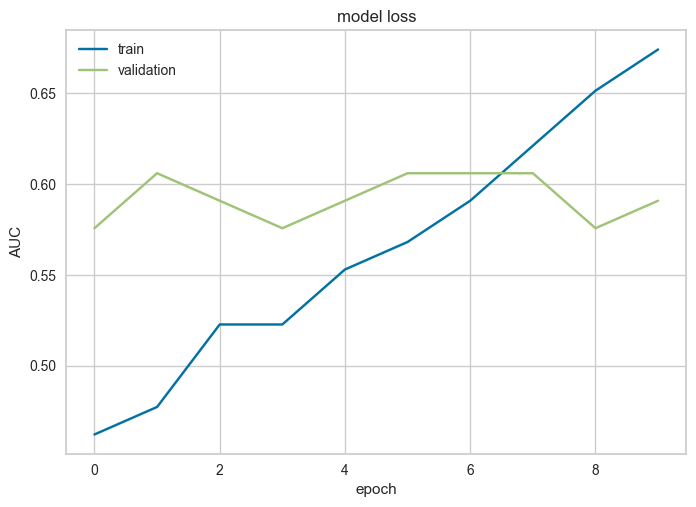

dict_keys(['loss', 'acc', 'auc', 'val_loss', 'val_acc', 'val_auc'])


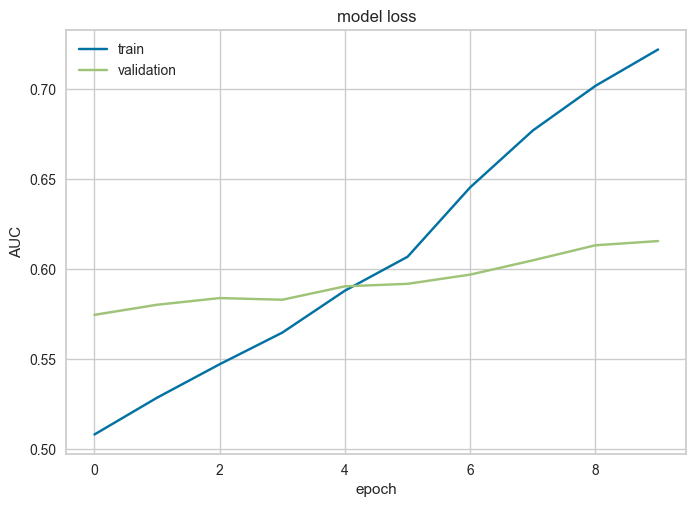

In [114]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(history.history.keys())
# "Loss"
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model loss')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

4/4 [==============================] - 0s 2ms/step


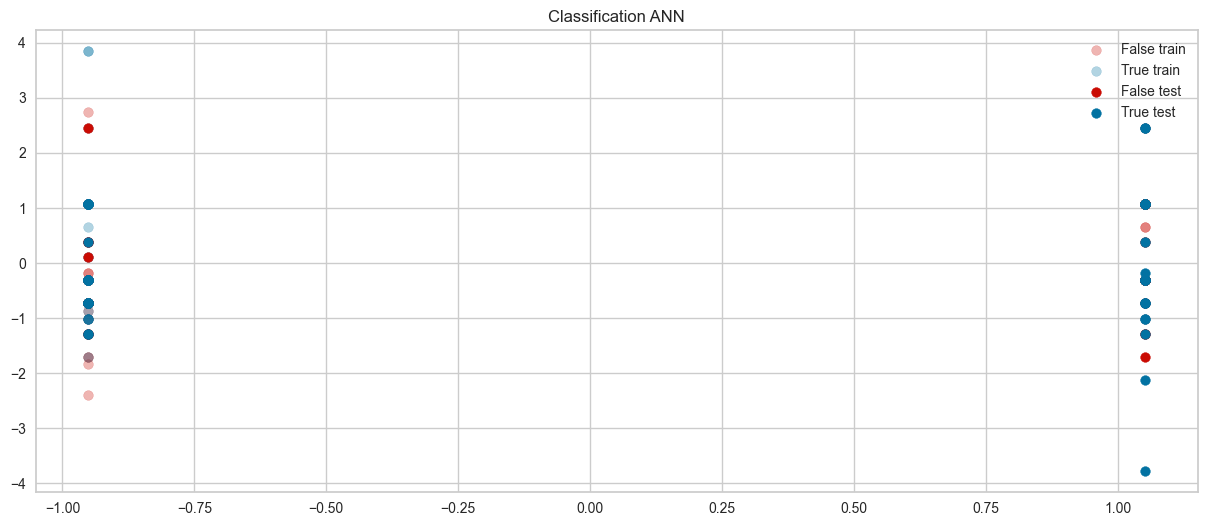

In [85]:
y_pred = model.predict(X_test) 

plt.figure(figsize=(15,6))

for res, c, name in zip([0,1], ['r', 'b'], ['False', 'True']):
    plt.scatter(X_train[:,0][y_train==res],X_train[:,1][y_train==res],c=c, label=name+' train', alpha=.3)
#color_mapping = [{0:'red',1:'green',2:'blue'}[i] for i in y_pred]


for res, c, name in zip([0,1], ['r', 'b'], ['False', 'True']):
    plt.scatter(X_test[:,0][y_test==res],X_test[:,1][y_test==res],c=c, label=name+' test')

plt.legend()
plt.title('Classification ANN');

In [86]:
accuracy_score(y_test, y_pred.round())

0.6060606060606061

In [87]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

         0.0       0.51      0.88      0.65        41
         1.0       0.83      0.41      0.55        58

    accuracy                           0.61        99
   macro avg       0.67      0.65      0.60        99
weighted avg       0.70      0.61      0.59        99



With this architecture, we can see that we got an accuracy of 0.79. When we conducted KNN we got an accuracy of 0.77.

To further train our model we can continue to run through the .fit method, as it continues to train the model and possibly increase accuracy.

Instead of manually running the method we can implement the callback function: Earlystopping. It allows for the model to stop training when the model does not see an increase within the training. These parameters are determined by "monitor" and "patience"

In [88]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=X_train.shape[1]))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(15, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc', 'AUC'])

history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.33,
                  callbacks=[keras.callbacks.EarlyStopping(monitor='acc', patience=10)])

Epoch 1/100
5/5 [==============================] - 1s 67ms/step - loss: 0.7323 - acc: 0.5000 - auc: 0.5119 - val_loss: 0.7536 - val_acc: 0.4242 - val_auc: 0.4567
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 0.7013 - acc: 0.5606 - auc: 0.5728 - val_loss: 0.7437 - val_acc: 0.4545 - val_auc: 0.4786
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6800 - acc: 0.5682 - auc: 0.6144 - val_loss: 0.7344 - val_acc: 0.4697 - val_auc: 0.5051
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6609 - acc: 0.6061 - auc: 0.6546 - val_loss: 0.7233 - val_acc: 0.5303 - val_auc: 0.5210
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6435 - acc: 0.6439 - auc: 0.6947 - val_loss: 0.7106 - val_acc: 0.5303 - val_auc: 0.5471
Epoch 6/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6269 - acc: 0.7045 - auc: 0.7338 - val_loss: 0.6994 - val_acc: 0.5758 - val_auc: 0.5685
Epoch 7/100
5/5 [===========

dict_keys(['loss', 'acc', 'auc', 'val_loss', 'val_acc', 'val_auc'])


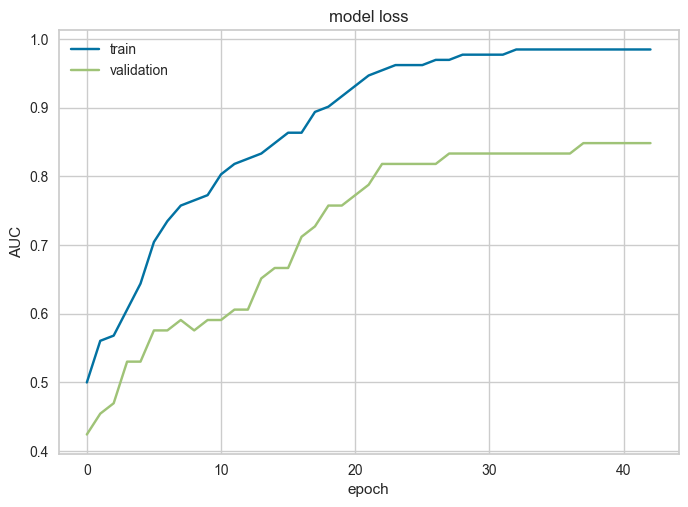

dict_keys(['loss', 'acc', 'auc', 'val_loss', 'val_acc', 'val_auc'])


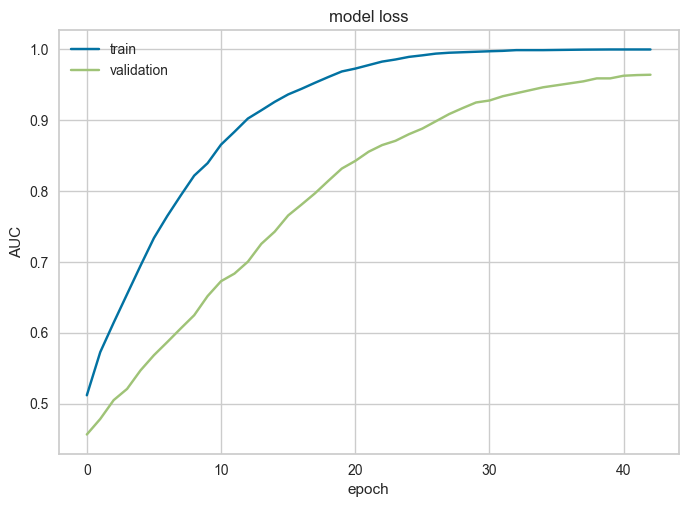

In [89]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(history.history.keys())
# "Loss"
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model loss')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

4/4 [==============================] - 0s 1ms/step


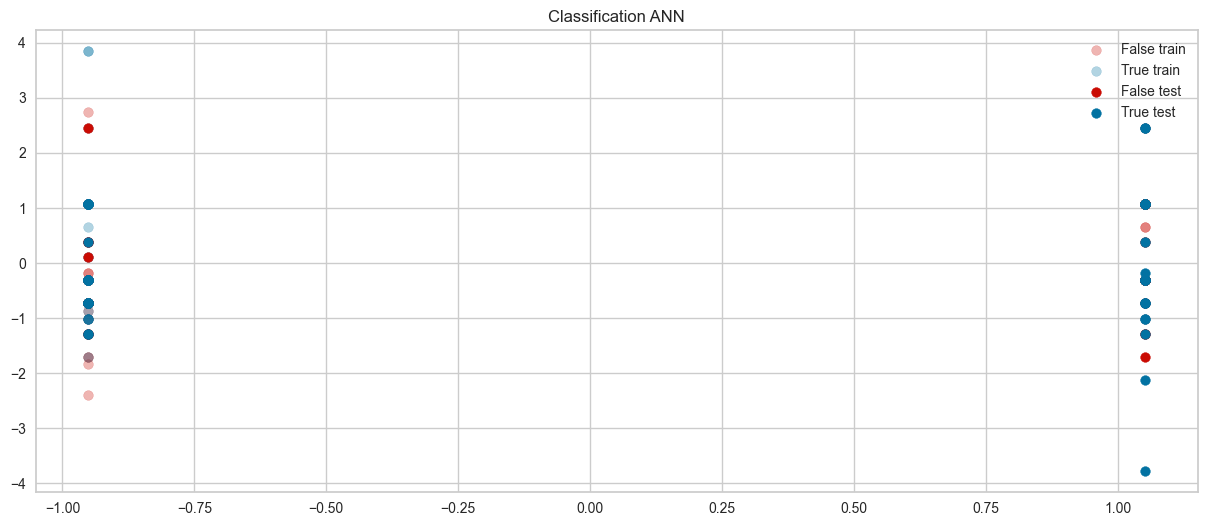

In [90]:
y_pred = model.predict(X_test) 

plt.figure(figsize=(15,6))

for res, c, name in zip([0,1], ['r', 'b'], ['False', 'True']):
    plt.scatter(X_train[:,0][y_train==res],X_train[:,1][y_train==res],c=c, label=name+' train', alpha=.3)
#color_mapping = [{0:'red',1:'green',2:'blue'}[i] for i in y_pred]


for res, c, name in zip([0,1], ['r', 'b'], ['False', 'True']):
    plt.scatter(X_test[:,0][y_test==res],X_test[:,1][y_test==res],c=c, label=name+' test')

plt.legend()
plt.title('Classification ANN');

In [91]:
accuracy_score(y_test, y_pred.round())

0.8888888888888888

Increase of 0.02 accuracy

In [92]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88        41
         1.0       0.98      0.83      0.90        58

    accuracy                           0.89        99
   macro avg       0.89      0.90      0.89        99
weighted avg       0.91      0.89      0.89        99



## Hyperparameter tuning with Random Search
To further increase the performance of the ANN we will look into hyperparameters and see what we can change to increase accuracy. Following what is described in ** the hyperparameters that have the most impact are number of "hidden layers", number of "neurons", and "learning_rate

1. We will create a function that creates an ANN model
2. Determine a dictionary that contains all hyperparameters we wish to investigate
3. Conduct Random Search
4. Evaluate best parameters
5. Create a new model, train it, and evaluate

In [93]:
def model_builder(n_hidden=1,n_neurons=30,learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X_train.shape[1]))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc', 'AUC'])
    return model

In [94]:
from sklearn.model_selection import RandomizedSearchCV

In [95]:
paramiters = {'n_hidden': np.arange(1,10), 'n_neurons': np.arange(1,300),
             'learning_rate': np.arange(3e-4 ,  3e-2)}

In [96]:
wrapper = keras.wrappers.scikit_learn.KerasClassifier(model_builder)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_6876\974583189.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  wrapper = keras.wrappers.scikit_learn.KerasClassifier(model_builder)


In [97]:
random_search = RandomizedSearchCV(estimator=wrapper,
                                   param_distributions=paramiters,
                                   n_iter=10,cv=3)

In [98]:
random_search.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.33,
                  callbacks=[keras.callbacks.EarlyStopping(monitor='acc', patience=10)])

Epoch 1/100


3/3 [==============================] - 2s 158ms/step - loss: 0.7167 - acc: 0.5000 - auc: 0.6460 - val_loss: 0.7371 - val_acc: 0.5682 - val_auc: 0.3337
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6710 - acc: 0.5227 - auc: 0.7372 - val_loss: 0.7177 - val_acc: 0.5455 - val_auc: 0.3789
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6348 - acc: 0.5909 - auc: 0.8057 - val_loss: 0.6996 - val_acc: 0.5455 - val_auc: 0.4379
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 0.6048 - acc: 0.6477 - auc: 0.8501 - val_loss: 0.6828 - val_acc: 0.5455 - val_auc: 0.5053
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 0.5785 - acc: 0.6705 - auc: 0.8842 - val_loss: 0.6666 - val_acc: 0.5682 - val_auc: 0.5632
Epoch 6/100
3/3 [==============================] - 0s 24ms/step - loss: 0.5554 - acc: 0.7500 - auc: 0.9106 - val_loss: 0.6501 - val_acc: 0.5455 - val_auc: 0.6179
Epoch 7/100
3/3 [======================

Epoch 1/100
3/3 [==============================] - 1s 134ms/step - loss: 0.7676 - acc: 0.4773 - auc: 0.5623 - val_loss: 0.6879 - val_acc: 0.5909 - val_auc: 0.5558
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 0.7047 - acc: 0.4773 - auc: 0.6519 - val_loss: 0.6729 - val_acc: 0.6364 - val_auc: 0.5747
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 0.6647 - acc: 0.5455 - auc: 0.7178 - val_loss: 0.6625 - val_acc: 0.6591 - val_auc: 0.6074
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6294 - acc: 0.6591 - auc: 0.7822 - val_loss: 0.6520 - val_acc: 0.5909 - val_auc: 0.6674
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 0.6026 - acc: 0.7614 - auc: 0.8354 - val_loss: 0.6415 - val_acc: 0.6364 - val_auc: 0.7011
Epoch 6/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5810 - acc: 0.7614 - auc: 0.8623 - val_loss: 0.6297 - val_acc: 0.6364 - val_auc: 0.7621
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 129ms/step - loss: 0.7005 - acc: 0.4318 - auc: 0.4715 - val_loss: 0.6717 - val_acc: 0.6136 - val_auc: 0.6716
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 0.6690 - acc: 0.5795 - auc: 0.6353 - val_loss: 0.6617 - val_acc: 0.7045 - val_auc: 0.7316
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 0.6443 - acc: 0.6591 - auc: 0.7611 - val_loss: 0.6526 - val_acc: 0.7500 - val_auc: 0.7632
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 0.6193 - acc: 0.7955 - auc: 0.8723 - val_loss: 0.6432 - val_acc: 0.7500 - val_auc: 0.7811
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 0.5959 - acc: 0.8636 - auc: 0.9249 - val_loss: 0.6330 - val_acc: 0.7500 - val_auc: 0.7958
Epoch 6/100
3/3 [==============================] - 0s 20ms/step - loss: 0.5730 - acc: 0.8977 - auc: 0.9545 - val_loss: 0.6215 - val_acc: 0.7500 - val_auc: 0.8095
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 172ms/step - loss: 0.6945 - acc: 0.4318 - auc: 0.4344 - val_loss: 0.6867 - val_acc: 0.5682 - val_auc: 0.6453
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 0.6803 - acc: 0.7386 - auc: 0.8780 - val_loss: 0.6797 - val_acc: 0.6591 - val_auc: 0.7147
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.6581 - acc: 0.8409 - auc: 0.9646 - val_loss: 0.6615 - val_acc: 0.6818 - val_auc: 0.7389
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6062 - acc: 0.8864 - auc: 0.9837 - val_loss: 0.6222 - val_acc: 0.7273 - val_auc: 0.7789
Epoch 5/100
3/3 [==============================] - 0s 38ms/step - loss: 0.5026 - acc: 0.9318 - auc: 0.9922 - val_loss: 0.5506 - val_acc: 0.7955 - val_auc: 0.8347
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 0.3435 - acc: 0.9545 - auc: 0.9840 - val_loss: 0.4734 - val_acc: 0.8182 - val_auc: 0.8779
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 3s 159ms/step - loss: 0.6888 - acc: 0.5114 - auc: 0.6282 - val_loss: 0.6984 - val_acc: 0.4318 - val_auc: 0.5400
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6643 - acc: 0.5568 - auc: 0.8721 - val_loss: 0.6956 - val_acc: 0.4545 - val_auc: 0.6042
Epoch 3/100
3/3 [==============================] - 0s 24ms/step - loss: 0.6161 - acc: 0.8182 - auc: 0.9375 - val_loss: 0.6806 - val_acc: 0.5455 - val_auc: 0.6737
Epoch 4/100
3/3 [==============================] - 0s 25ms/step - loss: 0.5373 - acc: 0.8864 - auc: 0.9602 - val_loss: 0.6754 - val_acc: 0.5227 - val_auc: 0.7368
Epoch 5/100
3/3 [==============================] - 0s 25ms/step - loss: 0.4181 - acc: 0.9545 - auc: 0.9770 - val_loss: 0.5749 - val_acc: 0.7045 - val_auc: 0.7916
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 0.2822 - acc: 0.9432 - auc: 0.9897 - val_loss: 0.5452 - val_acc: 0.7045 - val_auc: 0.8316
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 146ms/step - loss: 0.6896 - acc: 0.6250 - auc: 0.5500 - val_loss: 0.6945 - val_acc: 0.4318 - val_auc: 0.7263
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.6643 - acc: 0.5682 - auc: 0.8043 - val_loss: 0.6926 - val_acc: 0.4545 - val_auc: 0.7526
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 0.6116 - acc: 0.7386 - auc: 0.9367 - val_loss: 0.6795 - val_acc: 0.6136 - val_auc: 0.7621
Epoch 4/100
3/3 [==============================] - 0s 18ms/step - loss: 0.5263 - acc: 0.8182 - auc: 0.9628 - val_loss: 0.6876 - val_acc: 0.6136 - val_auc: 0.7916
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 0.3964 - acc: 0.8977 - auc: 0.9846 - val_loss: 0.6751 - val_acc: 0.6818 - val_auc: 0.8305
Epoch 6/100
3/3 [==============================] - 0s 20ms/step - loss: 0.2392 - acc: 0.9659 - auc: 0.9948 - val_loss: 0.6501 - val_acc: 0.7955 - val_auc: 0.8579
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 141ms/step - loss: 0.6988 - acc: 0.4773 - auc: 0.4592 - val_loss: 0.6793 - val_acc: 0.7500 - val_auc: 0.8021
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.6517 - acc: 0.8750 - auc: 0.9548 - val_loss: 0.6293 - val_acc: 0.8409 - val_auc: 0.9084
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.5191 - acc: 0.9773 - auc: 1.0000 - val_loss: 0.4818 - val_acc: 0.8636 - val_auc: 0.9242
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 0.2394 - acc: 0.9886 - auc: 1.0000 - val_loss: 0.2965 - val_acc: 0.8864 - val_auc: 0.9389
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0480 - acc: 0.9886 - auc: 1.0000 - val_loss: 0.3365 - val_acc: 0.8409 - val_auc: 0.9684
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0859 - acc: 0.9886 - auc: 0.9889 - val_loss: 1.2732 - val_acc: 0.7500 - val_auc: 0.8947
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 153ms/step - loss: 0.6938 - acc: 0.5114 - auc: 0.4889 - val_loss: 0.6886 - val_acc: 0.4318 - val_auc: 0.7842
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6351 - acc: 0.5682 - auc: 0.9636 - val_loss: 0.6481 - val_acc: 0.5909 - val_auc: 0.8789
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.4922 - acc: 0.8750 - auc: 0.9987 - val_loss: 0.5371 - val_acc: 0.7045 - val_auc: 0.9463
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2520 - acc: 0.9773 - auc: 1.0000 - val_loss: 0.2726 - val_acc: 0.8864 - val_auc: 0.9937
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0594 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.1152 - val_acc: 0.9318 - val_auc: 1.0000
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - acc: 1.0000 - auc: 1.0000 - val_loss: 1.7063 - val_acc: 0.7727 - val_auc: 0.8800
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 137ms/step - loss: 0.6830 - acc: 0.5682 - auc: 0.5691 - val_loss: 0.6906 - val_acc: 0.4318 - val_auc: 0.8179
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 0.6009 - acc: 0.7500 - auc: 0.9464 - val_loss: 0.6159 - val_acc: 0.7500 - val_auc: 0.8495
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.4235 - acc: 0.9091 - auc: 0.9770 - val_loss: 0.4882 - val_acc: 0.7955 - val_auc: 0.8737
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2279 - acc: 0.9545 - auc: 0.9950 - val_loss: 0.4751 - val_acc: 0.8636 - val_auc: 0.9200
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1022 - acc: 0.9545 - auc: 1.0000 - val_loss: 0.8961 - val_acc: 0.7727 - val_auc: 0.9600
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0103 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.3822 - val_acc: 0.9091 - val_auc: 0.9589
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 1s 119ms/step - loss: 0.6731 - acc: 0.5568 - auc: 0.6093 - val_loss: 0.6752 - val_acc: 0.5455 - val_auc: 0.6126
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6220 - acc: 0.5909 - auc: 0.7178 - val_loss: 0.6577 - val_acc: 0.5682 - val_auc: 0.6421
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5804 - acc: 0.7159 - auc: 0.8065 - val_loss: 0.6422 - val_acc: 0.5909 - val_auc: 0.6737
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 0.5438 - acc: 0.7841 - auc: 0.8682 - val_loss: 0.6277 - val_acc: 0.6136 - val_auc: 0.6937
Epoch 5/100
3/3 [==============================] - 0s 42ms/step - loss: 0.5092 - acc: 0.8636 - auc: 0.9207 - val_loss: 0.6163 - val_acc: 0.5909 - val_auc: 0.7032
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 0.4783 - acc: 0.8977 - auc: 0.9478 - val_loss: 0.6063 - val_acc: 0.5909 - val_auc: 0.7200
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 1s 107ms/step - loss: 0.7103 - acc: 0.5682 - auc: 0.5473 - val_loss: 0.7249 - val_acc: 0.4545 - val_auc: 0.4516
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6477 - acc: 0.6705 - auc: 0.7158 - val_loss: 0.6964 - val_acc: 0.5455 - val_auc: 0.5368
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5984 - acc: 0.7500 - auc: 0.8158 - val_loss: 0.6717 - val_acc: 0.5682 - val_auc: 0.6326
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5561 - acc: 0.8068 - auc: 0.8786 - val_loss: 0.6483 - val_acc: 0.6136 - val_auc: 0.6989
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5164 - acc: 0.8409 - auc: 0.9212 - val_loss: 0.6268 - val_acc: 0.6591 - val_auc: 0.7474
Epoch 6/100
3/3 [==============================] - 0s 19ms/step - loss: 0.4820 - acc: 0.8864 - auc: 0.9447 - val_loss: 0.6075 - val_acc: 0.6591 - val_auc: 0.7779
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 1s 113ms/step - loss: 0.6613 - acc: 0.5909 - auc: 0.6562 - val_loss: 0.6337 - val_acc: 0.7045 - val_auc: 0.7589
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5990 - acc: 0.6932 - auc: 0.8129 - val_loss: 0.6277 - val_acc: 0.7273 - val_auc: 0.7726
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5497 - acc: 0.7841 - auc: 0.9137 - val_loss: 0.6243 - val_acc: 0.7273 - val_auc: 0.7663
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 0.5060 - acc: 0.8977 - auc: 0.9597 - val_loss: 0.6220 - val_acc: 0.7045 - val_auc: 0.7558
Epoch 5/100
3/3 [==============================] - 0s 24ms/step - loss: 0.4701 - acc: 0.9205 - auc: 0.9720 - val_loss: 0.6226 - val_acc: 0.6818 - val_auc: 0.7389
Epoch 6/100
3/3 [==============================] - 0s 24ms/step - loss: 0.4354 - acc: 0.9318 - auc: 0.9780 - val_loss: 0.6211 - val_acc: 0.6818 - val_auc: 0.7368
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 143ms/step - loss: 0.6997 - acc: 0.5114 - auc: 0.4860 - val_loss: 0.6742 - val_acc: 0.6136 - val_auc: 0.7811
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.6175 - acc: 0.9091 - auc: 0.9677 - val_loss: 0.5851 - val_acc: 0.6591 - val_auc: 0.9137
Epoch 3/100
3/3 [==============================] - 0s 26ms/step - loss: 0.4040 - acc: 0.9318 - auc: 1.0000 - val_loss: 0.3446 - val_acc: 0.9091 - val_auc: 0.9589
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0876 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.1962 - val_acc: 0.9318 - val_auc: 0.9853
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0418 - acc: 0.9886 - auc: 1.0000 - val_loss: 1.6739 - val_acc: 0.6136 - val_auc: 0.9000
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2778 - acc: 0.9659 - auc: 0.9889 - val_loss: 0.2812 - val_acc: 0.9091 - val_auc: 0.9653
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 139ms/step - loss: 0.6870 - acc: 0.5682 - auc: 0.6413 - val_loss: 0.6534 - val_acc: 0.8864 - val_auc: 0.9716
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 0.5718 - acc: 0.9205 - auc: 0.9804 - val_loss: 0.4307 - val_acc: 0.9773 - val_auc: 0.9979
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2364 - acc: 0.9773 - auc: 0.9979 - val_loss: 0.1402 - val_acc: 0.9318 - val_auc: 1.0000
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0224 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000 - val_auc: 1.0000
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 9.1782e-05 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000 - val_auc: 1.0000
Epoch 6/100
3/3 [==============================] - 0s 24ms/step - loss: 2.9437e-07 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000 - val_auc: 1.0000
Epoch 7/100
3/3 [==

Epoch 1/100
3/3 [==============================] - 2s 167ms/step - loss: 0.6807 - acc: 0.6477 - auc: 0.5897 - val_loss: 0.6789 - val_acc: 0.4773 - val_auc: 0.8747
Epoch 2/100
3/3 [==============================] - 0s 26ms/step - loss: 0.5382 - acc: 0.8409 - auc: 0.9670 - val_loss: 0.5967 - val_acc: 0.7045 - val_auc: 0.8853
Epoch 3/100
3/3 [==============================] - 0s 25ms/step - loss: 0.2622 - acc: 0.9205 - auc: 1.0000 - val_loss: 0.2989 - val_acc: 0.8864 - val_auc: 0.9505
Epoch 4/100
3/3 [==============================] - 0s 27ms/step - loss: 0.0366 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.2951 - val_acc: 0.9091 - val_auc: 0.9674
Epoch 5/100
3/3 [==============================] - 0s 26ms/step - loss: 6.6817e-04 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.8167 - val_acc: 0.8864 - val_auc: 0.9579
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 1.2118e-05 - acc: 1.0000 - auc: 1.0000 - val_loss: 1.7611 - val_acc: 0.8409 - val_auc: 0.9400
Epoch 7/100
3/3 [==

Epoch 1/100
3/3 [==============================] - 1s 123ms/step - loss: 0.7062 - acc: 0.3864 - auc: 0.3473 - val_loss: 0.7011 - val_acc: 0.5000 - val_auc: 0.4621
Epoch 2/100
3/3 [==============================] - 0s 40ms/step - loss: 0.6583 - acc: 0.7614 - auc: 0.8318 - val_loss: 0.6923 - val_acc: 0.5909 - val_auc: 0.5200
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6186 - acc: 0.8864 - auc: 0.9527 - val_loss: 0.6844 - val_acc: 0.5682 - val_auc: 0.5653
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5730 - acc: 0.9205 - auc: 0.9711 - val_loss: 0.6740 - val_acc: 0.5909 - val_auc: 0.5895
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 0.5132 - acc: 0.9545 - auc: 0.9804 - val_loss: 0.6616 - val_acc: 0.5909 - val_auc: 0.6284
Epoch 6/100
3/3 [==============================] - 0s 19ms/step - loss: 0.4342 - acc: 0.9545 - auc: 0.9899 - val_loss: 0.6466 - val_acc: 0.6136 - val_auc: 0.6621
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 1s 122ms/step - loss: 0.6841 - acc: 0.5568 - auc: 0.5773 - val_loss: 0.6747 - val_acc: 0.5909 - val_auc: 0.6716
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 0.6342 - acc: 0.7727 - auc: 0.9103 - val_loss: 0.6523 - val_acc: 0.6136 - val_auc: 0.7537
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5788 - acc: 0.8977 - auc: 0.9796 - val_loss: 0.6234 - val_acc: 0.7273 - val_auc: 0.8095
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5128 - acc: 0.9432 - auc: 0.9907 - val_loss: 0.5810 - val_acc: 0.7955 - val_auc: 0.8505
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 0.4254 - acc: 0.9545 - auc: 0.9953 - val_loss: 0.5213 - val_acc: 0.8409 - val_auc: 0.8916
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 0.3196 - acc: 0.9659 - auc: 0.9964 - val_loss: 0.4472 - val_acc: 0.8636 - val_auc: 0.9074
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 129ms/step - loss: 0.7081 - acc: 0.4545 - auc: 0.6104 - val_loss: 0.6520 - val_acc: 0.6591 - val_auc: 0.8137
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.6557 - acc: 0.6818 - auc: 0.8671 - val_loss: 0.6508 - val_acc: 0.7955 - val_auc: 0.8316
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6175 - acc: 0.9432 - auc: 0.9652 - val_loss: 0.6366 - val_acc: 0.8182 - val_auc: 0.8274
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.5659 - acc: 0.9659 - auc: 0.9848 - val_loss: 0.6071 - val_acc: 0.8636 - val_auc: 0.8484
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 0.4951 - acc: 0.9886 - auc: 0.9950 - val_loss: 0.5698 - val_acc: 0.8409 - val_auc: 0.8505
Epoch 6/100
3/3 [==============================] - 0s 19ms/step - loss: 0.3985 - acc: 0.9886 - auc: 0.9992 - val_loss: 0.5288 - val_acc: 0.8182 - val_auc: 0.8653
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 150ms/step - loss: 0.6925 - acc: 0.5114 - auc: 0.5473 - val_loss: 0.6741 - val_acc: 0.6591 - val_auc: 0.7547
Epoch 2/100
3/3 [==============================] - 0s 27ms/step - loss: 0.6128 - acc: 0.9091 - auc: 0.9868 - val_loss: 0.5972 - val_acc: 0.7045 - val_auc: 0.8474
Epoch 3/100
3/3 [==============================] - 0s 29ms/step - loss: 0.3999 - acc: 0.9773 - auc: 0.9990 - val_loss: 0.4425 - val_acc: 0.7500 - val_auc: 0.8853
Epoch 4/100
3/3 [==============================] - 0s 28ms/step - loss: 0.1065 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.4679 - val_acc: 0.8636 - val_auc: 0.8989
Epoch 5/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0110 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.6468 - val_acc: 0.8636 - val_auc: 0.8905
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 6.9829e-05 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.9297 - val_acc: 0.8409 - val_auc: 0.9400
Epoch 7/100
3/3 [======

Epoch 1/100
3/3 [==============================] - 2s 165ms/step - loss: 0.6900 - acc: 0.5114 - auc: 0.5217 - val_loss: 0.6649 - val_acc: 0.6818 - val_auc: 0.8905
Epoch 2/100
3/3 [==============================] - 0s 29ms/step - loss: 0.5897 - acc: 0.8977 - auc: 0.9659 - val_loss: 0.5830 - val_acc: 0.6591 - val_auc: 0.9674
Epoch 3/100
3/3 [==============================] - 0s 24ms/step - loss: 0.3690 - acc: 0.9091 - auc: 0.9871 - val_loss: 0.3182 - val_acc: 0.9318 - val_auc: 0.9684
Epoch 4/100
3/3 [==============================] - 0s 25ms/step - loss: 0.1478 - acc: 0.9659 - auc: 0.9995 - val_loss: 0.2634 - val_acc: 0.9091 - val_auc: 0.9800
Epoch 5/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0116 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.6633 - val_acc: 0.7955 - val_auc: 0.9600
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0015 - acc: 1.0000 - auc: 1.0000 - val_loss: 1.1047 - val_acc: 0.7955 - val_auc: 0.9400
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 138ms/step - loss: 0.6977 - acc: 0.5682 - auc: 0.4424 - val_loss: 0.7069 - val_acc: 0.4318 - val_auc: 0.7737
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6276 - acc: 0.5909 - auc: 0.9736 - val_loss: 0.6854 - val_acc: 0.4773 - val_auc: 0.8042
Epoch 3/100
3/3 [==============================] - 0s 25ms/step - loss: 0.4830 - acc: 0.7955 - auc: 1.0000 - val_loss: 0.6451 - val_acc: 0.6136 - val_auc: 0.8305
Epoch 4/100
3/3 [==============================] - 0s 27ms/step - loss: 0.2430 - acc: 0.9773 - auc: 1.0000 - val_loss: 0.4916 - val_acc: 0.7955 - val_auc: 0.8547
Epoch 5/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0564 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.6745 - val_acc: 0.8409 - val_auc: 0.8958
Epoch 6/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0029 - acc: 1.0000 - auc: 1.0000 - val_loss: 1.2800 - val_acc: 0.8636 - val_auc: 0.9242
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 1s 137ms/step - loss: 0.8538 - acc: 0.5341 - auc: 0.5421 - val_loss: 0.9506 - val_acc: 0.5000 - val_auc: 0.3526
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 0.8343 - acc: 0.5341 - auc: 0.5530 - val_loss: 0.9389 - val_acc: 0.5000 - val_auc: 0.3537
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.8167 - acc: 0.5682 - auc: 0.5620 - val_loss: 0.9285 - val_acc: 0.5000 - val_auc: 0.3526
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.8002 - acc: 0.5795 - auc: 0.5752 - val_loss: 0.9178 - val_acc: 0.5000 - val_auc: 0.3547
Epoch 5/100
3/3 [==============================] - 0s 24ms/step - loss: 0.7840 - acc: 0.5795 - auc: 0.5889 - val_loss: 0.9081 - val_acc: 0.4773 - val_auc: 0.3568
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 0.7684 - acc: 0.5909 - auc: 0.6031 - val_loss: 0.8989 - val_acc: 0.4773 - val_auc: 0.3568
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 1s 130ms/step - loss: 0.7323 - acc: 0.5795 - auc: 0.5664 - val_loss: 0.6812 - val_acc: 0.6591 - val_auc: 0.6463
Epoch 2/100
3/3 [==============================] - 0s 20ms/step - loss: 0.7137 - acc: 0.6023 - auc: 0.5964 - val_loss: 0.6737 - val_acc: 0.6591 - val_auc: 0.6516
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6932 - acc: 0.6250 - auc: 0.6302 - val_loss: 0.6670 - val_acc: 0.6591 - val_auc: 0.6568
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6765 - acc: 0.6250 - auc: 0.6556 - val_loss: 0.6609 - val_acc: 0.6591 - val_auc: 0.6547
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 0.6605 - acc: 0.6477 - auc: 0.6716 - val_loss: 0.6549 - val_acc: 0.6591 - val_auc: 0.6600
Epoch 6/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6444 - acc: 0.6591 - auc: 0.6904 - val_loss: 0.6492 - val_acc: 0.6591 - val_auc: 0.6758
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 1s 134ms/step - loss: 0.7270 - acc: 0.5000 - auc: 0.6415 - val_loss: 0.6673 - val_acc: 0.6591 - val_auc: 0.6926
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.7035 - acc: 0.5341 - auc: 0.6675 - val_loss: 0.6601 - val_acc: 0.6591 - val_auc: 0.6916
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.6828 - acc: 0.5795 - auc: 0.6881 - val_loss: 0.6538 - val_acc: 0.6818 - val_auc: 0.6958
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6644 - acc: 0.6023 - auc: 0.7020 - val_loss: 0.6477 - val_acc: 0.6818 - val_auc: 0.6989
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6467 - acc: 0.6023 - auc: 0.7203 - val_loss: 0.6424 - val_acc: 0.6818 - val_auc: 0.7021
Epoch 6/100
3/3 [==============================] - 0s 25ms/step - loss: 0.6286 - acc: 0.6477 - auc: 0.7397 - val_loss: 0.6368 - val_acc: 0.6818 - val_auc: 0.7105
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 3s 174ms/step - loss: 0.6943 - acc: 0.4545 - auc: 0.4682 - val_loss: 0.6813 - val_acc: 0.5682 - val_auc: 0.6884
Epoch 2/100
3/3 [==============================] - 0s 28ms/step - loss: 0.6565 - acc: 0.6023 - auc: 0.9168 - val_loss: 0.6219 - val_acc: 0.7955 - val_auc: 0.8653
Epoch 3/100
3/3 [==============================] - 0s 28ms/step - loss: 0.4684 - acc: 0.9773 - auc: 0.9953 - val_loss: 0.5214 - val_acc: 0.6818 - val_auc: 0.8779
Epoch 4/100
3/3 [==============================] - 0s 28ms/step - loss: 0.1881 - acc: 0.9773 - auc: 0.9912 - val_loss: 0.3140 - val_acc: 0.8409 - val_auc: 0.9379
Epoch 5/100
3/3 [==============================] - 0s 27ms/step - loss: 0.1930 - acc: 0.9773 - auc: 0.9863 - val_loss: 0.3135 - val_acc: 0.8636 - val_auc: 0.9442
Epoch 6/100
3/3 [==============================] - 0s 29ms/step - loss: 0.1081 - acc: 0.9886 - auc: 0.9853 - val_loss: 1.5509 - val_acc: 0.6591 - val_auc: 0.8800
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 3s 188ms/step - loss: 0.6860 - acc: 0.5909 - auc: 0.6401 - val_loss: 0.6599 - val_acc: 0.7273 - val_auc: 0.8874
Epoch 2/100
3/3 [==============================] - 0s 30ms/step - loss: 0.5498 - acc: 0.9091 - auc: 0.9556 - val_loss: 0.4669 - val_acc: 0.8636 - val_auc: 0.9295
Epoch 3/100
3/3 [==============================] - 0s 31ms/step - loss: 0.2163 - acc: 0.9659 - auc: 0.9855 - val_loss: 0.4546 - val_acc: 0.7955 - val_auc: 0.9642
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0532 - acc: 0.9659 - auc: 1.0000 - val_loss: 0.2092 - val_acc: 0.9318 - val_auc: 0.9747
Epoch 5/100
3/3 [==============================] - 0s 44ms/step - loss: 0.0036 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.6529 - val_acc: 0.8636 - val_auc: 0.9368
Epoch 6/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0029 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.2740 - val_acc: 0.9091 - val_auc: 0.9716
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 3s 169ms/step - loss: 0.6882 - acc: 0.5455 - auc: 0.5319 - val_loss: 0.7029 - val_acc: 0.4318 - val_auc: 0.8032
Epoch 2/100
3/3 [==============================] - 0s 26ms/step - loss: 0.6232 - acc: 0.5909 - auc: 0.9414 - val_loss: 0.6639 - val_acc: 0.5455 - val_auc: 0.8105
Epoch 3/100
3/3 [==============================] - 0s 24ms/step - loss: 0.4027 - acc: 0.8864 - auc: 0.9882 - val_loss: 0.5381 - val_acc: 0.7955 - val_auc: 0.8179
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 0.1426 - acc: 0.9773 - auc: 1.0000 - val_loss: 1.2922 - val_acc: 0.6818 - val_auc: 0.9453
Epoch 5/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0346 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.7581 - val_acc: 0.9091 - val_auc: 0.9411
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0675 - acc: 0.9773 - auc: 1.0000 - val_loss: 1.1235 - val_acc: 0.9091 - val_auc: 0.9579
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 3s 155ms/step - loss: 0.6920 - acc: 0.5227 - auc: 0.5240 - val_loss: 0.6718 - val_acc: 0.6591 - val_auc: 0.6905
Epoch 2/100
3/3 [==============================] - 0s 33ms/step - loss: 0.6304 - acc: 0.8295 - auc: 0.9594 - val_loss: 0.6345 - val_acc: 0.7273 - val_auc: 0.7832
Epoch 3/100
3/3 [==============================] - 0s 46ms/step - loss: 0.5539 - acc: 0.8295 - auc: 0.9649 - val_loss: 0.5715 - val_acc: 0.7273 - val_auc: 0.8253
Epoch 4/100
3/3 [==============================] - 0s 38ms/step - loss: 0.4306 - acc: 0.9773 - auc: 0.9948 - val_loss: 0.5144 - val_acc: 0.7727 - val_auc: 0.8505
Epoch 5/100
3/3 [==============================] - 0s 30ms/step - loss: 0.2584 - acc: 0.9886 - auc: 1.0000 - val_loss: 0.4591 - val_acc: 0.7045 - val_auc: 0.8716
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 0.1209 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.4346 - val_acc: 0.7955 - val_auc: 0.8968
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 446ms/step - loss: 0.6807 - acc: 0.6364 - auc: 0.6946 - val_loss: 0.6555 - val_acc: 0.8182 - val_auc: 0.8747
Epoch 2/100
3/3 [==============================] - 0s 28ms/step - loss: 0.5907 - acc: 0.9091 - auc: 0.9736 - val_loss: 0.5779 - val_acc: 0.8636 - val_auc: 0.9211
Epoch 3/100
3/3 [==============================] - 0s 26ms/step - loss: 0.4426 - acc: 0.9545 - auc: 0.9928 - val_loss: 0.4635 - val_acc: 0.8636 - val_auc: 0.9568
Epoch 4/100
3/3 [==============================] - 0s 25ms/step - loss: 0.2383 - acc: 0.9773 - auc: 1.0000 - val_loss: 0.2509 - val_acc: 0.9773 - val_auc: 0.9768
Epoch 5/100
3/3 [==============================] - 0s 27ms/step - loss: 0.0796 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.1548 - val_acc: 0.9545 - val_auc: 0.9895
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0115 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.1708 - val_acc: 0.9545 - val_auc: 0.9979
Epoch 7/100
3/3 [==========

Epoch 1/100
3/3 [==============================] - 2s 135ms/step - loss: 0.6849 - acc: 0.5795 - auc: 0.5557 - val_loss: 0.7116 - val_acc: 0.4545 - val_auc: 0.4895
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.6048 - acc: 0.7955 - auc: 0.9610 - val_loss: 0.6850 - val_acc: 0.5909 - val_auc: 0.6442
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.4851 - acc: 0.9091 - auc: 0.9856 - val_loss: 0.6614 - val_acc: 0.6818 - val_auc: 0.7179
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.3074 - acc: 0.9432 - auc: 0.9979 - val_loss: 0.6214 - val_acc: 0.7273 - val_auc: 0.7811
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1360 - acc: 0.9886 - auc: 0.9995 - val_loss: 0.6770 - val_acc: 0.7955 - val_auc: 0.8305
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0362 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.8376 - val_acc: 0.7727 - val_auc: 0.8663
Epoch 7/100
3/3 [==========

Epoch 1/100
5/5 [==============================] - 2s 86ms/step - loss: 0.6980 - acc: 0.4621 - auc: 0.4565 - val_loss: 0.6797 - val_acc: 0.6667 - val_auc: 0.9007
Epoch 2/100
5/5 [==============================] - 0s 21ms/step - loss: 0.6509 - acc: 0.7424 - auc: 0.9586 - val_loss: 0.5351 - val_acc: 0.7879 - val_auc: 0.9748
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 0.3690 - acc: 0.9242 - auc: 0.9838 - val_loss: 0.2316 - val_acc: 0.9091 - val_auc: 0.9776
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0775 - acc: 0.9848 - auc: 0.9995 - val_loss: 0.1829 - val_acc: 0.9394 - val_auc: 0.9856
Epoch 5/100
5/5 [==============================] - 0s 18ms/step - loss: 0.1360 - acc: 0.9697 - auc: 0.9886 - val_loss: 0.1020 - val_acc: 0.9848 - val_auc: 0.9911
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0059 - acc: 1.0000 - auc: 1.0000 - val_loss: 0.2124 - val_acc: 0.9091 - val_auc: 0.9953
Epoch 7/100
5/5 [===========

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000015BA91B7C10>,
                   param_distributions={'learning_rate': array([0.0003]),
                                        'n_hidden': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_neurons': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48...
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299])})

In [99]:
random_search.best_params_

{'n_neurons': 250, 'n_hidden': 9, 'learning_rate': 0.0003}

In [100]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=X_train.shape[1]))
model.add(keras.layers.Dense(166, activation='relu'))
model.add(keras.layers.Dense(166, activation='relu'))
model.add(keras.layers.Dense(166, activation='relu'))
model.add(keras.layers.Dense(166, activation='relu'))
model.add(keras.layers.Dense(166, activation='relu'))
model.add(keras.layers.Dense(166, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0003),metrics=['acc', 'AUC'])
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_220 (Dense)           (None, 166)               5810      
                                                                 
 dense_221 (Dense)           (None, 166)               27722     
                                                                 
 dense_222 (Dense)           (None, 166)               27722     
                                                                 
 dense_223 (Dense)           (None, 166)               27722     
                                                                 
 dense_224 (Dense)           (None, 166)               27722     
                                                                 
 dense_225 (Dense)           (None, 166)               27722     
                                                                 
 dense_226 (Dense)           (None, 1)               

In [101]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.33,
                  callbacks=[keras.callbacks.EarlyStopping(monitor='acc', patience=10)])

Epoch 1/100
5/5 [==============================] - 2s 64ms/step - loss: 0.6910 - acc: 0.5000 - auc: 0.5371 - val_loss: 0.6562 - val_acc: 0.7576 - val_auc: 0.8816
Epoch 2/100
5/5 [==============================] - 0s 13ms/step - loss: 0.6181 - acc: 0.8258 - auc: 0.9386 - val_loss: 0.5602 - val_acc: 0.8333 - val_auc: 0.9623
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 0.4652 - acc: 0.9470 - auc: 0.9893 - val_loss: 0.3636 - val_acc: 0.9091 - val_auc: 0.9828
Epoch 4/100
5/5 [==============================] - 0s 14ms/step - loss: 0.2177 - acc: 0.9773 - auc: 0.9962 - val_loss: 0.2120 - val_acc: 0.9091 - val_auc: 0.9944
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 0.0443 - acc: 0.9924 - auc: 1.0000 - val_loss: 0.0864 - val_acc: 0.9697 - val_auc: 0.9939
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 0.0117 - acc: 0.9924 - auc: 1.0000 - val_loss: 0.1148 - val_acc: 0.9394 - val_auc: 0.9972
Epoch 7/100
5/5 [===========

dict_keys(['loss', 'acc', 'auc', 'val_loss', 'val_acc', 'val_auc'])


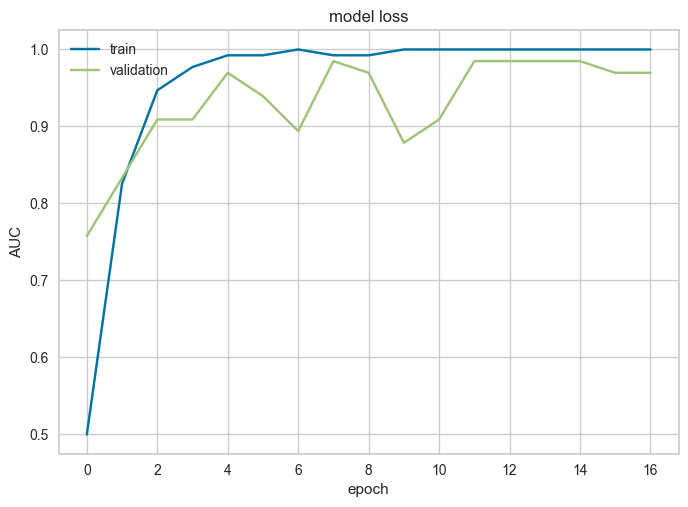

dict_keys(['loss', 'acc', 'auc', 'val_loss', 'val_acc', 'val_auc'])


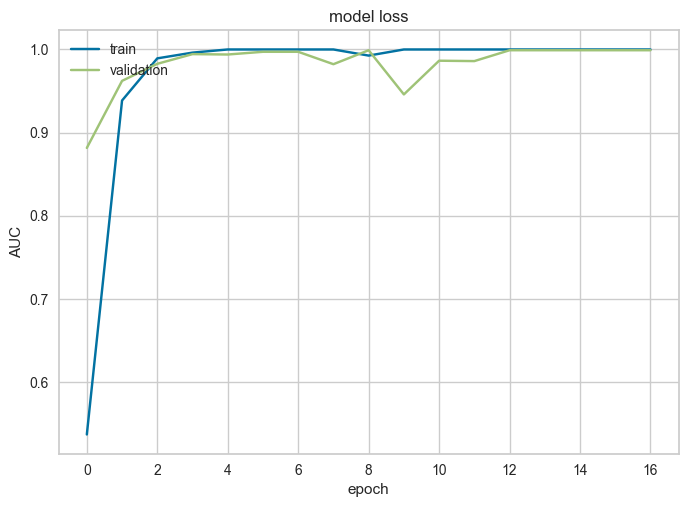

In [102]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print(history.history.keys())
# "Loss"
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model loss')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

4/4 [==============================] - 0s 2ms/step


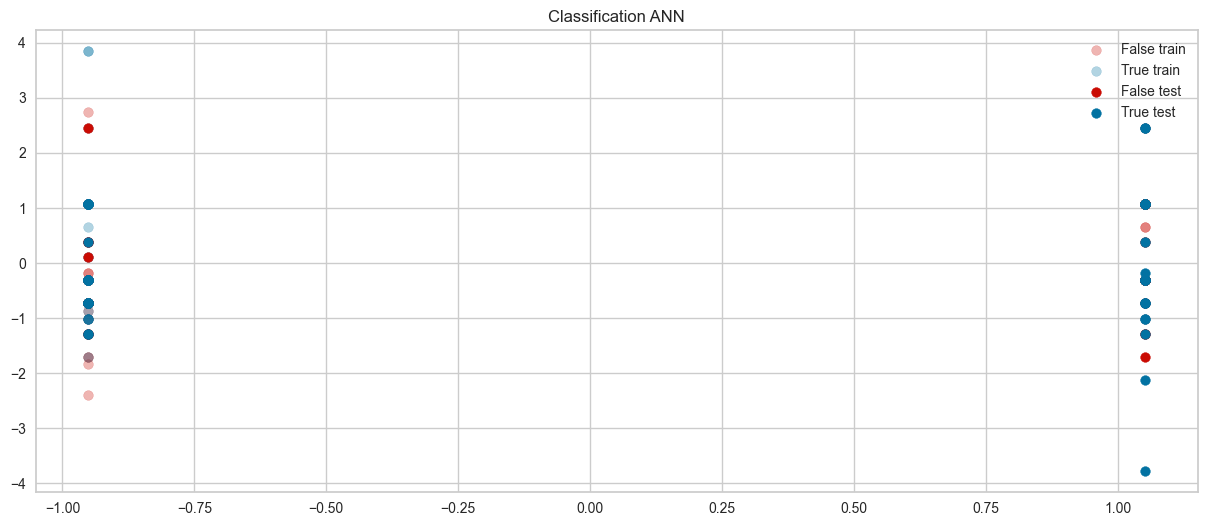

In [103]:
y_pred = model.predict(X_test) 

plt.figure(figsize=(15,6))

for res, c, name in zip([0,1], ['r', 'b'], ['False', 'True']):
    plt.scatter(X_train[:,0][y_train==res],X_train[:,1][y_train==res],c=c, label=name+' train', alpha=.3)
#color_mapping = [{0:'red',1:'green',2:'blue'}[i] for i in y_pred]


for res, c, name in zip([0,1], ['r', 'b'], ['False', 'True']):
    plt.scatter(X_test[:,0][y_test==res],X_test[:,1][y_test==res],c=c, label=name+' test')

plt.legend()
plt.title('Classification ANN');

In [104]:
accuracy_score(y_test, y_pred.round())

0.98989898989899

Increase of 0.009 accuracy.

In [105]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        41
         1.0       0.98      1.00      0.99        58

    accuracy                           0.99        99
   macro avg       0.99      0.99      0.99        99
weighted avg       0.99      0.99      0.99        99



## ANN - Regression
In the following section, we will present the creation of an ANN that is used for regression.
A large part of the development is much the same as with the creation of ANN for classification.

For this example I have found a dataset made for regression on Kaggle: winequality-red.csv
https://www.kaggle.com/datasets/sh6147782/winequalityred

In [106]:
df = pd.read_csv('winequality-red.csv')
df

FileNotFoundError: [Errno 2] No such file or directory: 'winequality-red.csv'

In [ ]:
X = df.drop(['quality'],axis=1).values
y = df['quality'].values

X = StandardScaler().fit_transform(X)   

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
print('X_train.shape:',X_train.shape)
print('X_test.shape:',X_test.shape)
print('y_train.shape:',y_train.shape)
print('y_test.shape:',y_test.shape)

X_train.shape: (1071, 11)
X_test.shape: (528, 11)
y_train.shape: (1071,)
y_test.shape: (528,)


To investigate regression issues we will change the architecture so that loss will look at mean_squared_error to evaluate the model.

For regression there is only a need to use the activation function of 'relu'

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=X_train.shape[1])) #input layer
model.add(keras.layers.Dense(30, activation='relu')) #Hidden layer 1
model.add(keras.layers.Dense(15, activation='relu')) #Hidden layer 2
model.add(keras.layers.Dense(1)) #Activation='relu' #output layer - can use activation relu but it is not needed to have an activation function within output layer for regression
model.summary()
model.compile(loss='mse',optimizer='adam',metrics=['mse'])

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_212 (Dense)           (None, 30)                360       
                                                                 
 dense_213 (Dense)           (None, 15)                465       
                                                                 
 dense_214 (Dense)           (None, 1)                 16        
                                                                 
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.33,
                  callbacks=[keras.callbacks.EarlyStopping(monitor='mse', patience=10)])

Epoch 1/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3834 - mse: 0.3834 - val_loss: 0.4715 - val_mse: 0.4715
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3852 - mse: 0.3852 - val_loss: 0.4834 - val_mse: 0.4834
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3795 - mse: 0.3795 - val_loss: 0.4722 - val_mse: 0.4722
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3833 - mse: 0.3833 - val_loss: 0.4689 - val_mse: 0.4689
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3777 - mse: 0.3777 - val_loss: 0.5070 - val_mse: 0.5070
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3776 - mse: 0.3776 - val_loss: 0.4628 - val_mse: 0.4628
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3743 - mse: 0.3743 - val_loss: 0.4704 - val_mse: 0.4704
Epoch 8/100
23/23 [==============================] - 0s 5ms/step - loss: 0.3791 - m

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


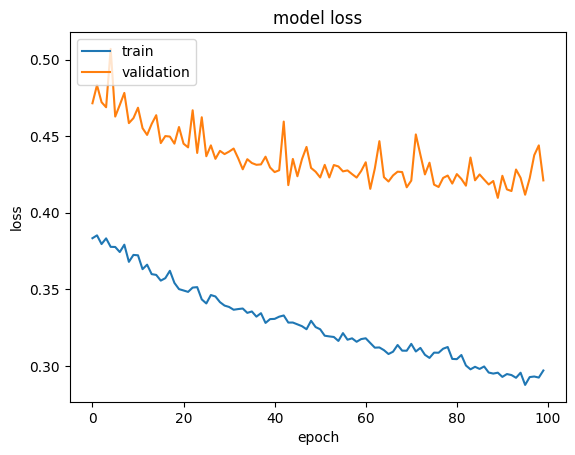

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_loss = model.evaluate(X_test, y_test)

17/17 [==============================] - 0s 2ms/step - loss: 0.4318 - mse: 0.4318
